In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append('/Users/Josh/Documents/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

## Import training data

In [4]:
# import pickle

# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
#     statFiles_scraped = pickle.load(file)

In [5]:
# keys_toDelete = [
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
#     '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
# ]
# for key in keys_toDelete:
#     del statFiles_scraped[key]

In [6]:
# sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

# images_all = np.concatenate(sf_list, axis=0)

# images_all.shape

In [7]:
# images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# # create validation set
# # X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
# X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
# (X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

<IPython.core.display.Javascript object>


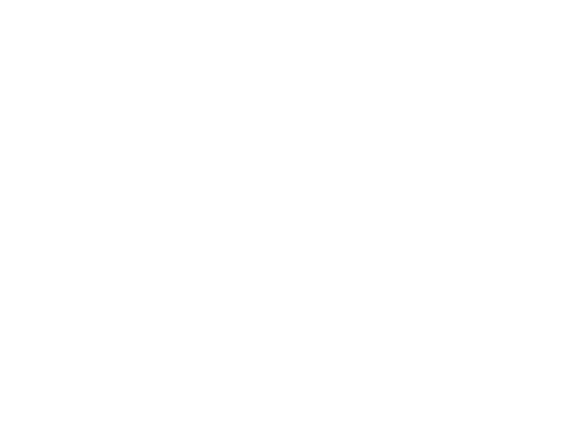

<IPython.core.display.Javascript object>


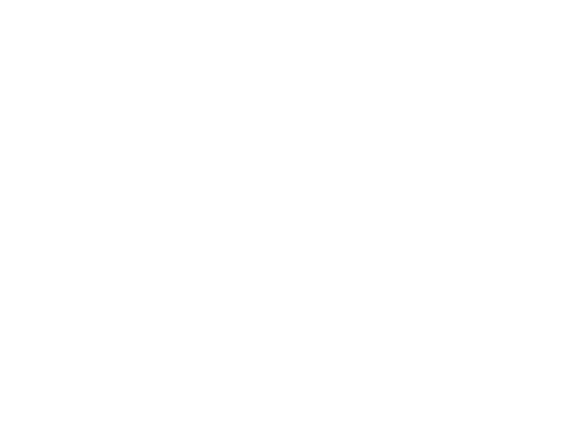

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


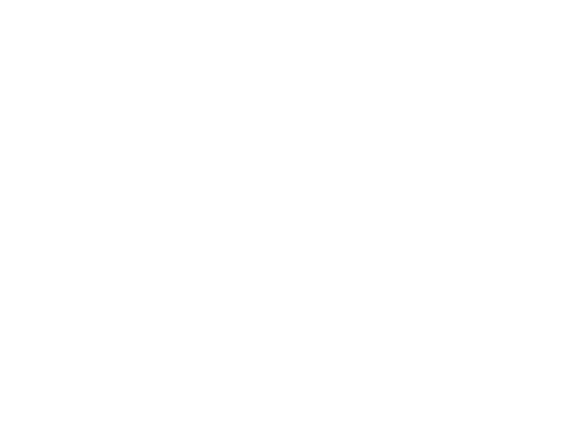

<IPython.core.display.Javascript object>


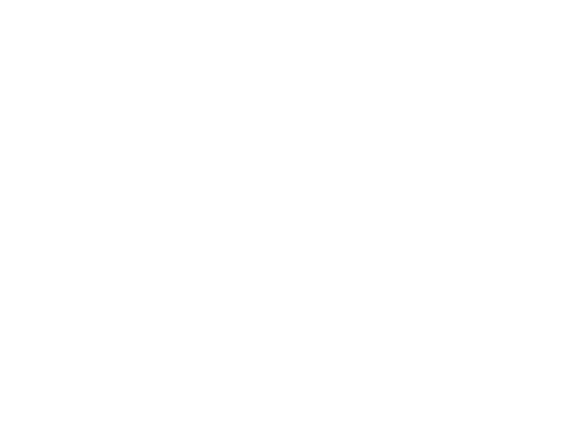

In [9]:
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [11]:
# tmpd = pd.DataFrame(labels)
# tmpd[1] = tmpd[0]
# tmpd.groupby(0).count()

In [12]:
#code doesn't work with multiple open number maybe (?)

In [13]:
def squeeze_integers(arr):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    RH 2021
    Args:
        arr (np.ndarray):
            array of integers.
    
    Returns:
        arr_squeezed (np.ndarray):
            array of integers with consecutive numbers
    """
    uniques = np.unique(arr)
    arr_squeezed = copy.deepcopy(arr)
    for val in np.arange(0, np.max(arr)+1):
        if np.isin(val, uniques):
            continue
        else:
            arr_squeezed[arr_squeezed>val] = arr_squeezed[arr_squeezed>val]-1
    return arr_squeezed

In [14]:
labels = squeeze_integers(labels)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = squeeze_integers(labels)

In [15]:
np.unique(labels)

array([0, 1, 2, 3])

In [16]:
labels

array([0, 1, 0, ..., 3, 3, 3])

## Balance classes of inputs

In [17]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 36, 36)
(9714,)
532
532
620
0
0
(9714, 36, 36)
(9714,)


In [18]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_dup[:], labels_dup[:], test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((8256, 36, 36), (8256,)), ((1458, 36, 36), (1458,)))

In [19]:
plt.figure()
plt.hist(labels_dup, 20);

<IPython.core.display.Javascript object>

## Define augmentation pipeline

In [30]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.5)),
    
#     torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.3, 0.3),
#                                         scale=(0.7, 1.7), 
#                                         shear=(-30, 30, -30, 30), 
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
    
#     augmentation.AddPoissonNoise(   level_bounds=(0,0.7),
#                                     prob=1),

#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.4,
#                                     prob=1),
)
# scripted_transforms = torch.jit.script(transforms)
scripted_transforms = transforms



dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1024,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=False,
#                                                 num_workers=32,
                                                num_workers=0,
#                                                 num_workers=16,
#                                                 prefetch_factor=3,
#                                                 persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

0.00027680397033691406


<IPython.core.display.Javascript object>


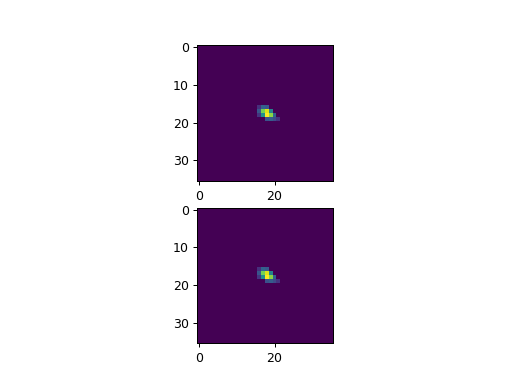

0.0877070426940918


<IPython.core.display.Javascript object>


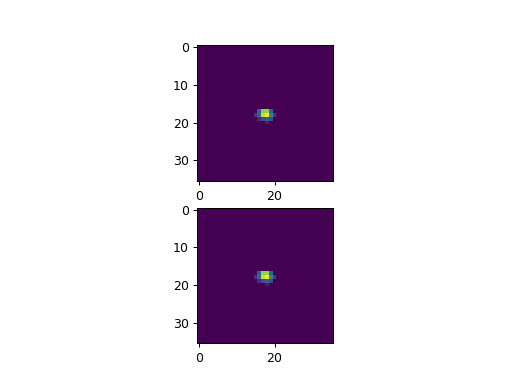

0.03706002235412598


<IPython.core.display.Javascript object>


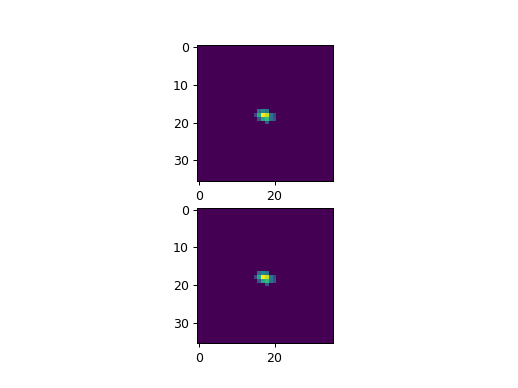

0.03780198097229004


<IPython.core.display.Javascript object>


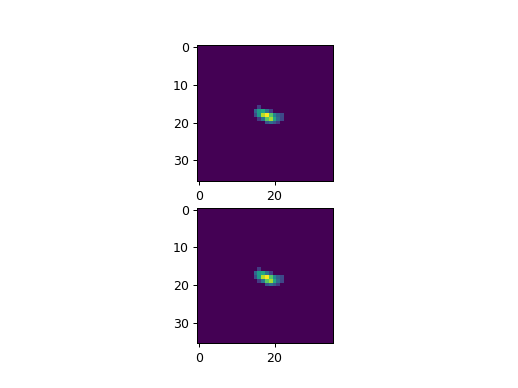

In [31]:
import time

%matplotlib notebook
tic=time.time()
for ii, im in enumerate(dataset_train):
#     for jj in range(im[0])
    print(time.time() - tic)
    tic = time.time()
#     print((im[0][0]).shape)
    fig, axs = plt.subplots(len(im[0]))
    for jj, ax in enumerate(axs):
        ax.imshow(im[0][jj].cpu().squeeze())
    if ii > 2:
        break

## Train

In [33]:
DEVICE = torch_helpers.set_device(use_GPU=True)

no GPU available. Using CPU.


In [34]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=128)
model.train()
# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0005,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [35]:
sys.path.append('/Users/Josh/Documents/github_repos/GCaMP_ROI_classifier/old_stuff/')

In [36]:
import numpy as np
from training_classHead import HeadModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# classHead = HeadModel(model, RandomForestClassifier)
classHead = HeadModel(model, LogisticRegression)
dataset_train.headmodel = classHead

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=10,
                               )
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
    classHead.fit(X_train[:, None, :, :], y_train, solver='liblinear')
    
    proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
    final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
#     print(class_weights)

    dataset_train.set_classweights(final_weights)
    
    print('dataset_train.final_weights', dataset_train.class_weights)


epoch: 0
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
Iter: 0/8, loss_train: 7.4612, loss_val: nan, lr: 0.0009995
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
double_sample_weights tensor([1., 1., 1.,  ..., 1., 1., 1.])
dataset_train.final_weights [0.25 0.25 0.25 0.25]
epoch: 1
double_sample_weights tensor([0.2506, 0.2501, 0.2551,  ..., 0.2828, 0.2509, 0.4308],
       dtype=torch.float64)
Iter: 0/8, loss_train: 6.5711, loss_val: nan, lr: 0.00099551
double_sample_weights tensor([0.2541, 0.4732, 0.2500,  ..., 0.2500, 0.2504, 0.4420],
       dtype=torch.float64)
double_sample_weights tensor([0.4694, 0.2518, 0.2502,  ..., 0.2500, 0.4751, 0.2513],
       dtype

KeyboardInterrupt: 

In [37]:
classHead

In [38]:
proba = classHead.predict_proba(dataset_train.X)

In [39]:
# classHead.fit(X_train[:, None, :, :], y_train)



proba = classHead.predict_proba(X_train[:, None, :, :])
final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])

dataset_train.set_classweights(final_weights)


In [40]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
logreg = LogisticRegression(solver='liblinear')
head = classHead.get_simCLR_head(X_train[:, None, ...])
# head = classHead.norm_head(head)
# head = head[:, [_ for _ in range(64) if _ not in [7, 15, 20, 21, 36, 54, 57, 60, 61, 62, 63, 64]]]
components , scores , decomposition.explained_variance_ratio_ , stds = decomposition.simple_pca(head, n_components=None)

# logreg.fit(scores[:, :], y_train)
# logreg.predict_proba(scores[:, :])
logreg.fit(head, y_train)
logreg.predict_proba(head)

array([[2.90435937e-10, 2.25857841e-08, 8.46720851e-07, 9.99999130e-01],
       [9.17411468e-12, 3.36470337e-09, 4.44537456e-07, 9.99999552e-01],
       [1.67727494e-09, 1.05596201e-06, 9.36749598e-05, 9.99905267e-01],
       ...,
       [5.48188870e-07, 8.58299654e-06, 4.33494077e-05, 9.99947519e-01],
       [2.60592324e-09, 3.44788070e-08, 1.91827059e-07, 9.99999771e-01],
       [5.28489498e-07, 4.01541299e-05, 1.31952993e-03, 9.98639787e-01]])

<IPython.core.display.Javascript object>


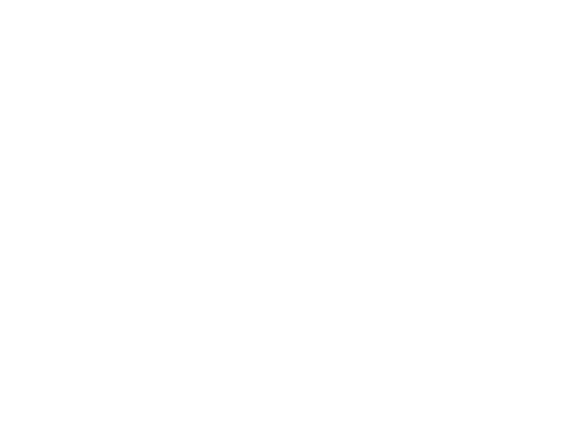

In [42]:
prd = logreg.predict_proba(head)
# prd = logreg.predict_proba(scores[:, :2])
plt.figure()
# plt.plot(logreg.predict_proba(scores[:, :2]))
plt.plot(logreg.predict_proba(head))

In [43]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(head), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

array([[0.63, 0.24, 0.04, 0.  ],
       [0.28, 0.5 , 0.27, 0.  ],
       [0.08, 0.23, 0.5 , 0.03],
       [0.02, 0.02, 0.19, 0.97]])

In [44]:
logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :]))

array([[3.87672314e-01, 3.56658989e-01, 2.14517284e-01, 4.11514131e-02],
       [3.98273376e-12, 1.57402518e-10, 1.71736980e-09, 9.99999998e-01],
       [4.50130105e-07, 3.82075857e-05, 1.47073286e-03, 9.98490609e-01],
       ...,
       [1.30165225e-06, 4.77837617e-04, 2.51310237e-02, 9.74389837e-01],
       [5.26975612e-09, 3.43499267e-07, 5.89420032e-06, 9.99993757e-01],
       [4.71619456e-08, 1.04013672e-06, 1.26614516e-05, 9.99986251e-01]])

In [45]:
cm = confusion_matrix(y_val, np.argmax(logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :])), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

array([[0.64, 0.3 , 0.09, 0.  ],
       [0.3 , 0.42, 0.28, 0.  ],
       [0.03, 0.25, 0.45, 0.03],
       [0.03, 0.04, 0.18, 0.96]])

In [46]:
y_val.shape

(1458,)

In [47]:
y_train.shape

(8256,)

In [49]:
logreg.score((components @ classHead.get_simCLR_head(X_val[:, None, ...]).T).T[:, :2], y_val)

ValueError: X has 2 features per sample; expecting 64

In [ ]:
plt.figure()
plt.plot(y_train)

In [ ]:
head.shape

In [ ]:
plt.figure()
plt.imshow(scores[:, :2], aspect='auto', interpolation='none')

In [ ]:
for colnum in range(64):
    print(head[:, colnum].min(), head[:, colnum].max(), head[:, colnum].mean(), head[:, colnum].std())

In [ ]:
import pandas as pd
with pd.option_context('max_rows', 1000, 'max_columns', 1000):
    display(pd.DataFrame(head).corr())

In [ ]:
classHead.headmodel.predict_proba(head)

In [ ]:
classHead.fit(X_train[:, None, :, :], y_train)

In [ ]:
classHead.predict_proba(X_train[:, None, :, :])

In [ ]:
# df = pd.DataFrame(np.concatenate([classHead.predict(X_val[:, None, :, :]).reshape(-1,1), y_val.reshape(-1,1)], -1))
# confusion_matrix(df[1], df[0])
# df

In [ ]:
idx_sample = 5
classHead.predict_proba(X_train[idx_sample:idx_sample+1, None, ...])

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=dataset_train.class_weights)

In [ ]:
sample_weight

In [ ]:
proba.shape

In [ ]:
X_train.shape

In [ ]:
for tmp in range(0,1):
    v = dataset_train.__getitem__(tmp)
#     if abs(v[-1].item() - 0.2) >= 0.001:
#         print(v)
#     print(v)

In [ ]:
dataset_train.__getitem__(0)

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(((np.abs(dataset_train.tmp.numpy() - X_train[0:1, None, ...]) > 0.01 )*255).squeeze())
# plt.imshow(((X_train[0:1, None, ...] != 0)*255).squeeze())

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(classHead.predict_proba(X_train[:,None,...])), temperature=1, class_value=dataset_train.class_weights)
sample_weight

## Check embeddings

In [50]:
torch.cuda.empty_cache()

In [51]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [52]:
# _, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [53]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=90.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

In [54]:
features_embedded

array([[ -6.818563 ,  37.74747  ],
       [ -4.8002186,  55.76984  ],
       [-12.171818 ,  45.421658 ],
       ...,
       [-13.593075 , -43.47303  ],
       [ 36.13085  , -15.043228 ],
       [-23.69723  ,  31.645529 ]], dtype=float32)

<IPython.core.display.Javascript object>


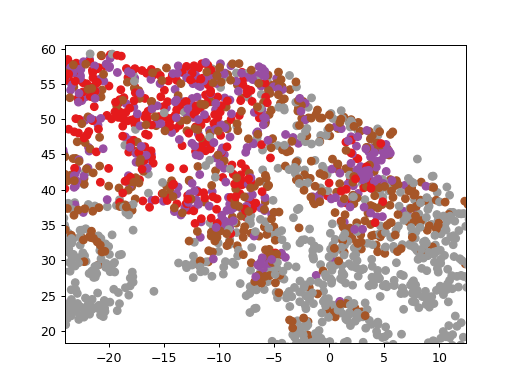

In [55]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [56]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


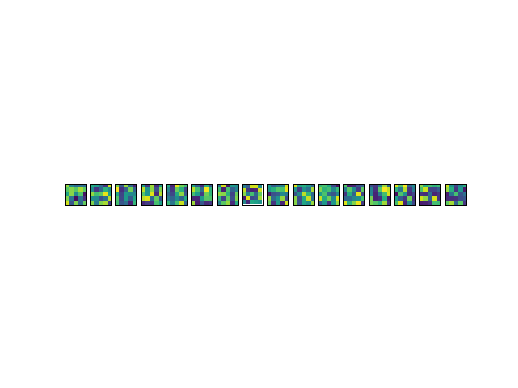

<IPython.core.display.Javascript object>


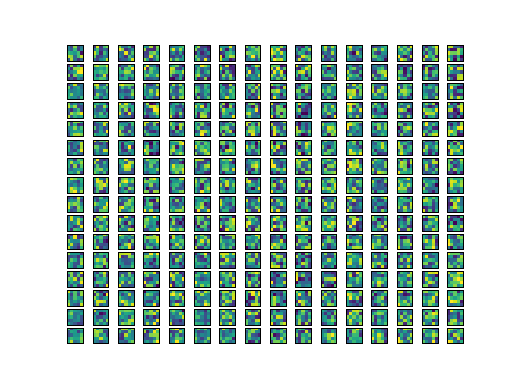

<IPython.core.display.Javascript object>


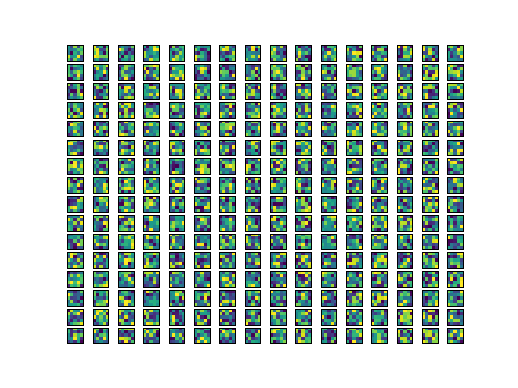

<IPython.core.display.Javascript object>


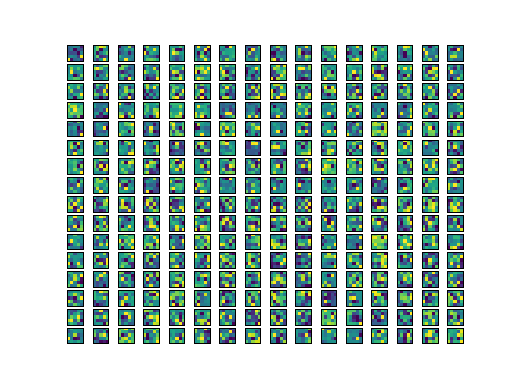

In [57]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()